In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from timeit import timeit

In [12]:
nx_full = 9000 + 1 #объявление переменных размера полной задачи
ny_full = 9000 + 1 # добавляем 1, чтобы избежать деления на 0 

nx = 500 + 1 #размер уменьшенной задачи
ny = 500 + 1

xmin = -3 #границы задачи
xmax = 3
ymin = -3
ymax = 3

eps = 0.0001 #будем считать, что точка сошлась с корнем, если они различаются на eps
r1, r2, r3 = np.roots([1, 0, 0, -1]) #у кубического уравнения три корня, используем np.roots, чтобы найти их 

In [13]:
@njit(fastmath = True)
def newton_point(z, eps, maxit = 1000):
    '''
        Вычисляет количество итераций для приближения к корню с заданной погрешностью (глубину).
            
            Аргументы:
                z (comp): Комплексное число
                eps (float): Погрешность
                maxit (int): Ограничение на количество итераций

            Возвращает:
                l (int): Количество итераций, необходимых для приближения к одному из корней уравнения z^3 - 1 = 0 с погрешностью eps
        
        Используется метод Ньютона для нахождения нуля функции:
        Z_n+1 = Z_n - p(z) / (p'(z)), где p - функция, а p' - производная этой функции
        
        В данном случае p(z) = z^3 - 1, а p'(z) = 3z^2.
    '''
    for i in range(maxit):
        z = z - (z**3 - 1) / (3 * (z**2))
        if abs(z - r1) < eps or abs(z - r2) < eps or abs(z - r3) < eps:
          break
    return i

In [14]:
@njit(fastmath = True, parallel = True)
def newton_plot(xmin, xmax, ymin, ymax, nx, ny, eps, maxit = 1000):
    '''
        Вычисляет бассейн Ньютона для заданного количества точек в заданной области с заданной погрешностью.

            Аргументы:
                xmin (float): Левая граница области
                xmax (float): Правая граница области
                ymin (float): Нижняя граница области
                ymax (float): Верхняя граница области
                nx (int): Количество точек по оси Ox (ширина)
                ny (int): Количество точек по оси Oy (высота)
                eps (float): Погрешность
                maxit (int): Ограничение на количество итераций

            Возвращает:
                res (np.array): Двумерный массив, состоящий из глубин для каждой точки в заданной области        
    '''
    dx = (xmax - xmin) / nx 
    dy = (ymax - ymin) / ny #шаги (разбиваем отрезок на дискретные точки)

    res = np.empty((ny, nx), dtype=np.uint16)

    for i in prange(ny):
        for j in range(nx):
          x = xmin + dx * j
          y = ymin + dy * i
          it = newton_point(x + 1j * y, eps, maxit)
          res[i, j] = it
    return res

In [15]:
t = timeit("newton_plot(xmin, xmax, ymin, ymax, nx, ny, eps)", number = 20, globals = globals()) / 20 #считаем среднее время для выполения уменьшенной задачи
t * (nx_full * ny_full) / (nx * ny) / 60 #оцениваем время выполнения полной задачи (в минутах)

0.4607745150338881

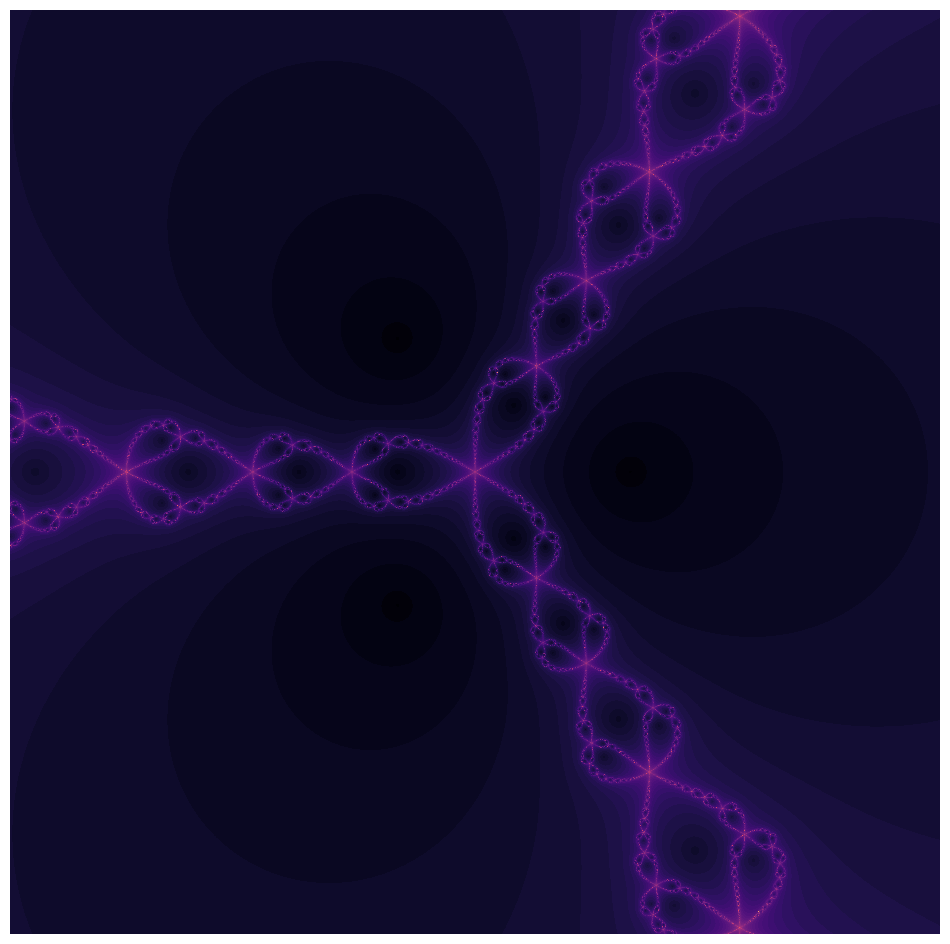

In [16]:
newton_res = newton_plot(xmin, xmax, ymin, ymax, nx_full, ny_full, eps)

r = 2 #отвечает за растяжение отображаемой картинки 
plt.figure(figsize=((xmax-xmin) * r, (ymax - ymin) * r))
plt.axis('off')

plt.pcolormesh(newton_res, cmap = 'magma')

In [17]:
import holoviews as hv
from holoviews import opts
from holoviews.streams import RangeXY

In [18]:
im_w, im_h = 600, 600 #ширина и высота отображаемого участка интерактивной карты
maxit = 200 #ограничение на количество итераций для интерактивной карты

def get_newton(x_range, y_range,im_w = 600, im_h = 600, eps = 0.0001, maxit = 200):
    ''' 
    Вычисляет бассейн Ньютона в заданной области для интерактивной карты

        Аргументы:
            x_range (tuple): Границы области по оси Ox
            y_range (tuple): Границы области по оси Oy
            im_w (int): Ширина области
            im_h (int): Высота области
            eps (float): Погрешность
            maxit (int): Ограничение на количество итераций

        Возвращает:
            img (hv.image): Картинка, бассейн Ньютона для заданной области

    Использует функцию newton_plot.        
    '''
    x0, x1 = x_range #границы по Ox
    y0, y1 = y_range #границы по Oy

    arr = newton_plot(x0, x1, -y1, -y0, im_w, im_h, eps, maxit)

    img = hv.Image(arr, bounds=(x0, y0, x1, y1))
    return img

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
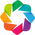

:DynamicMap   []
   :Image   [x,y]   (z)

In [19]:
hv.extension('bokeh')

range_stream = RangeXY(x_range = (xmin, xmax), y_range = (ymin, ymax))

dmap = hv.DynamicMap(get_newton, streams= [range_stream]) 

dmap.opts(opts.Image(cmap = 'magma', height = im_h, width = im_w))

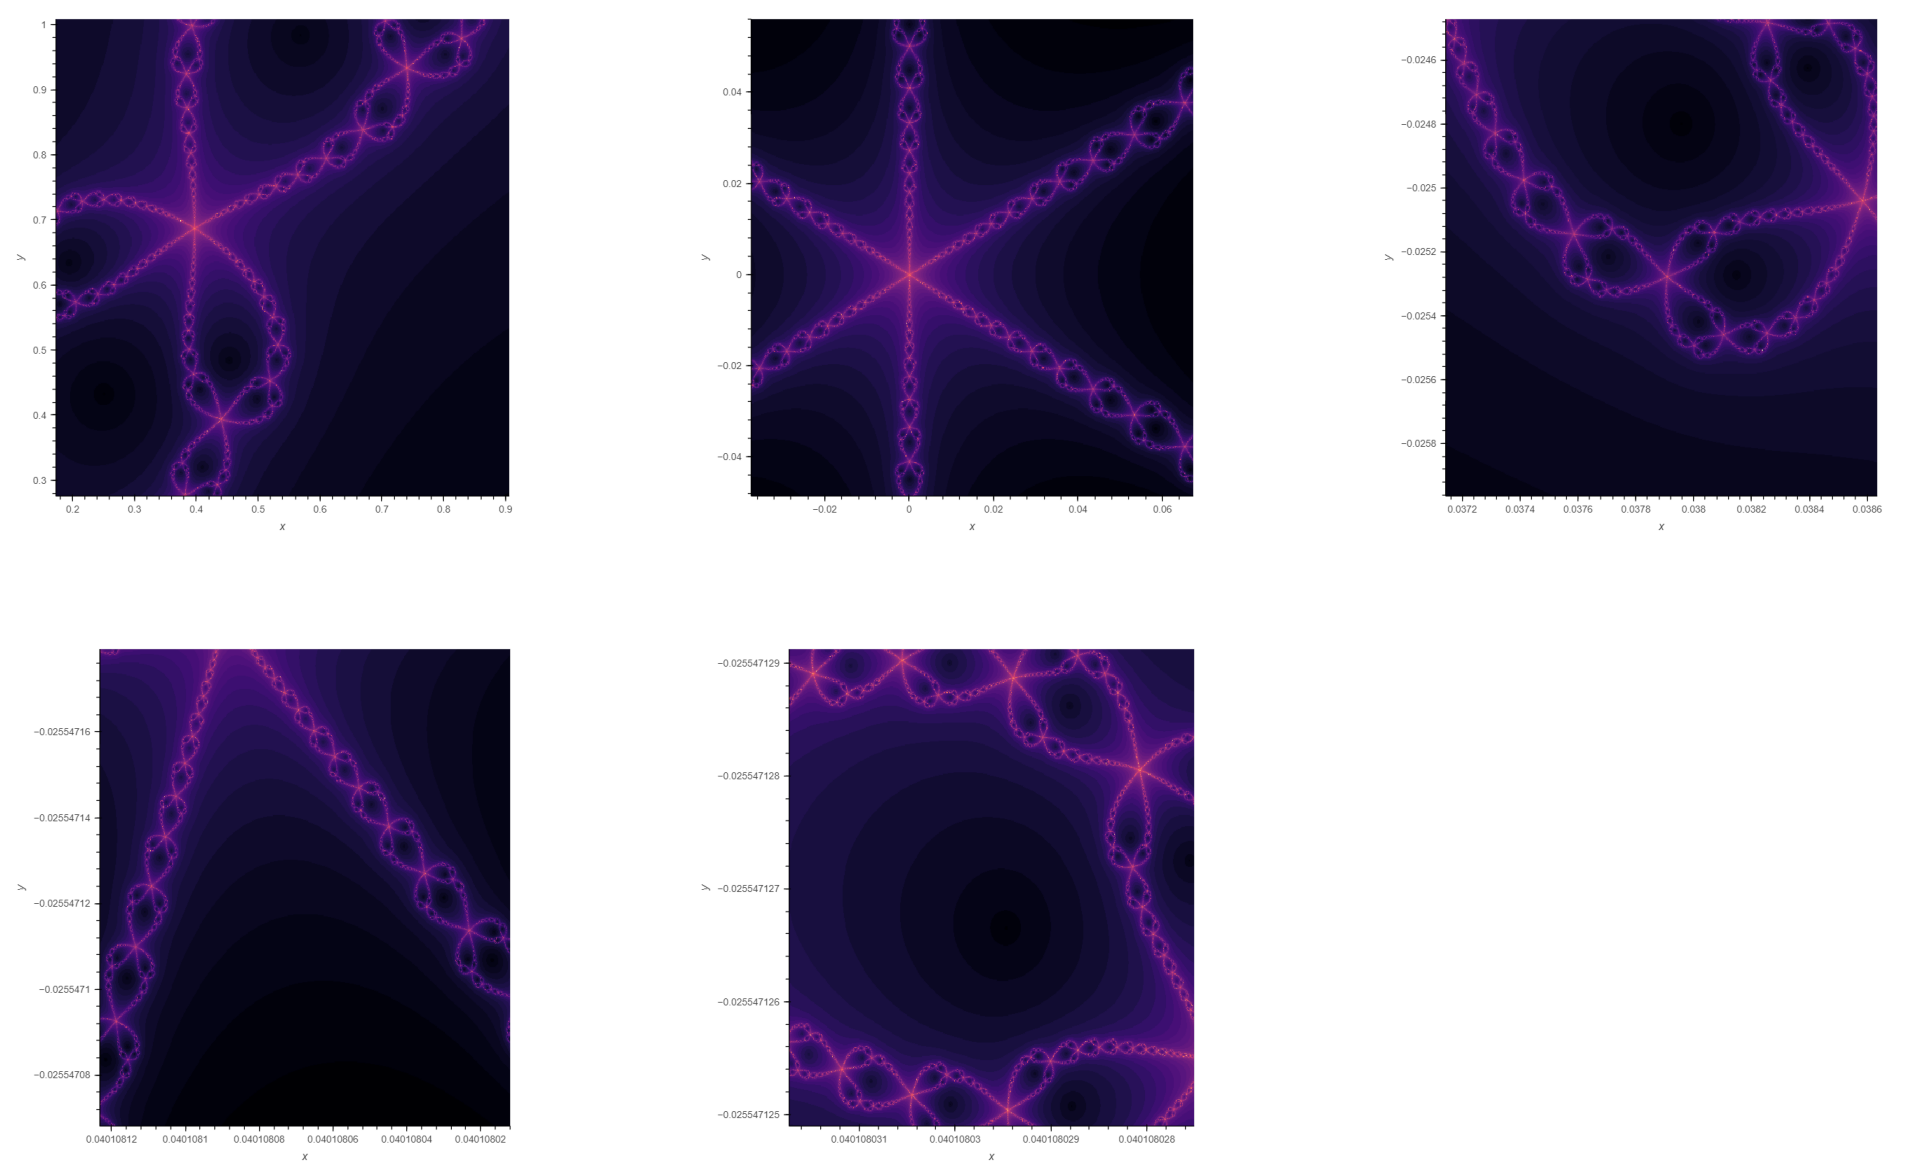

In [20]:
from PIL import Image
pic = plt.figure(figsize = (25, 15))
for i in range(1, 6):
    ax = pic.add_subplot(2, 3, i)
    ax.axis('off')
    ax.imshow(Image.open('newtonfr' + str(i) + '.png'))
plt.show()

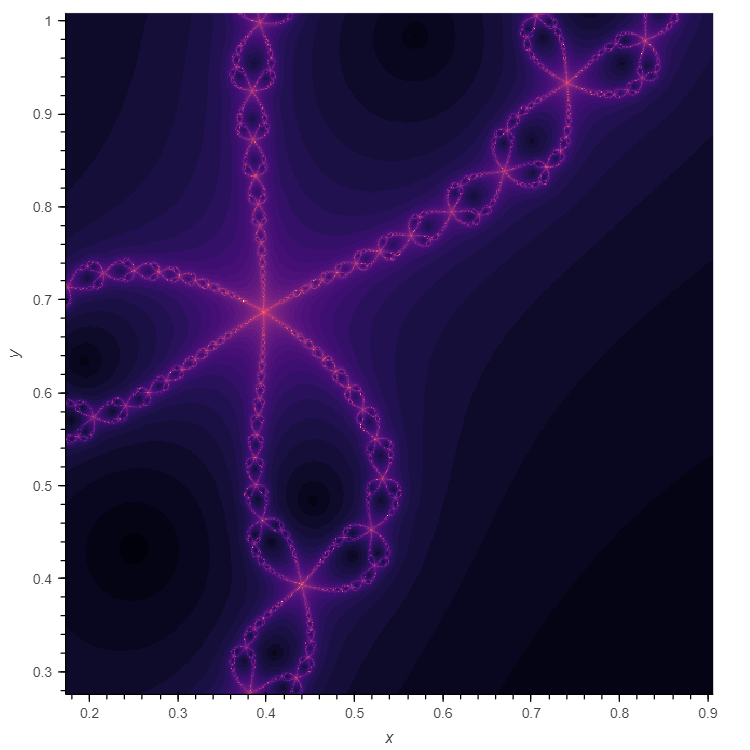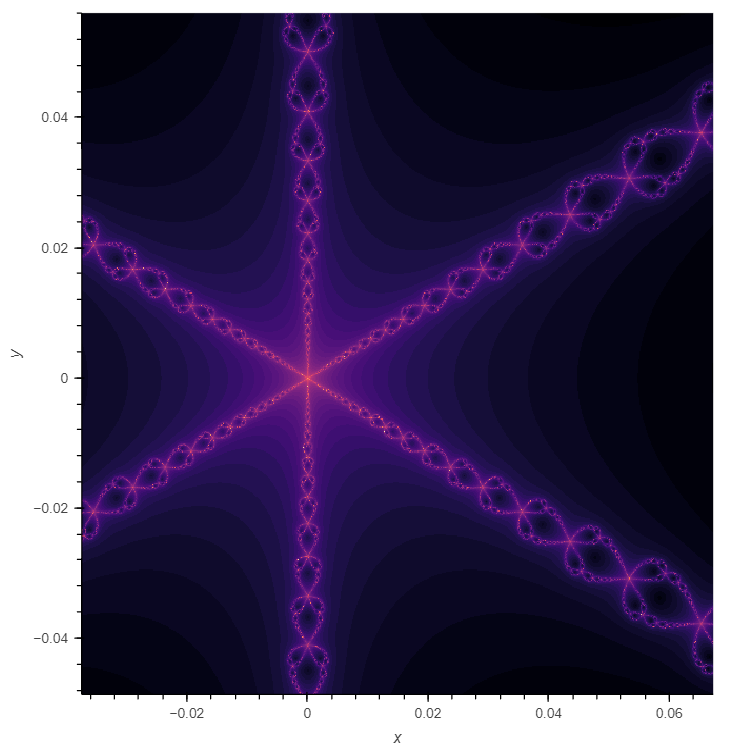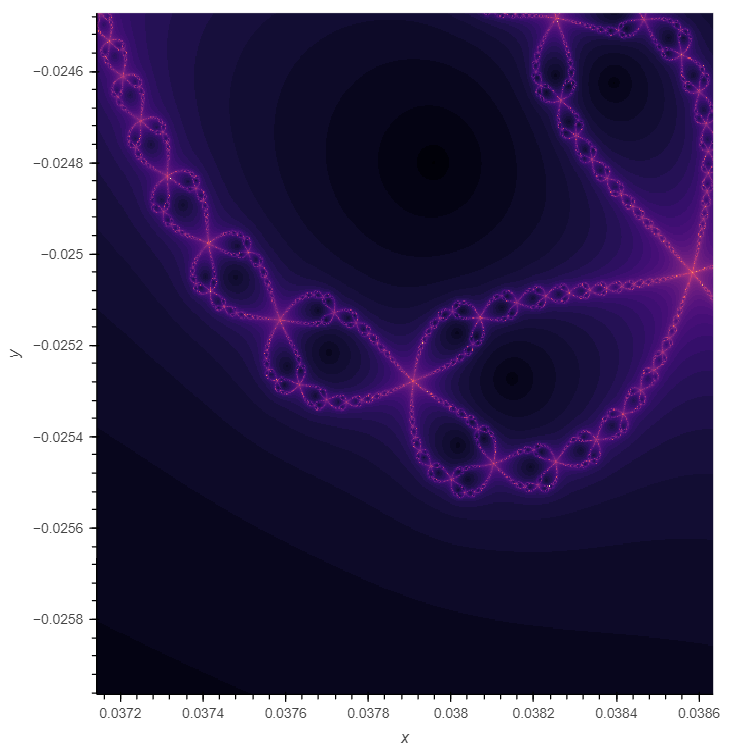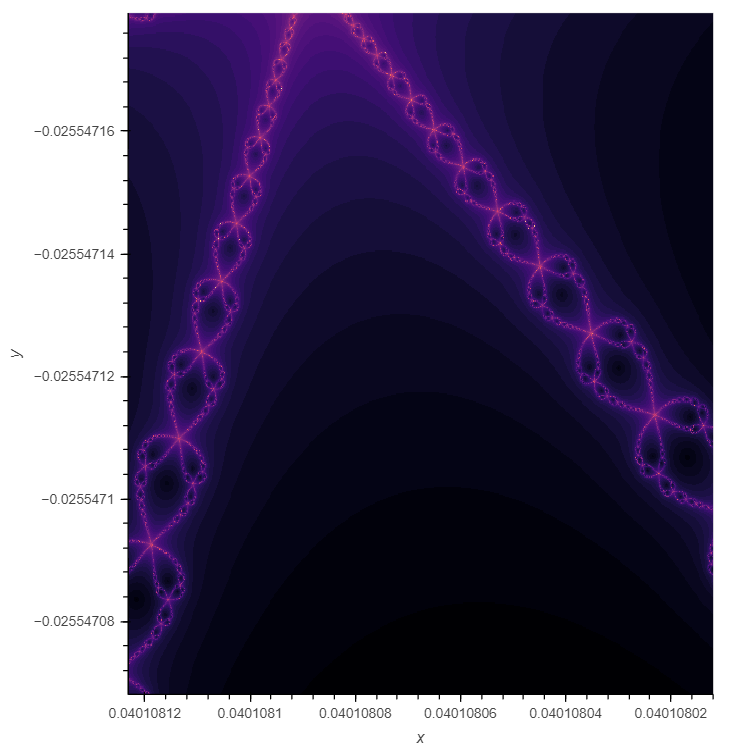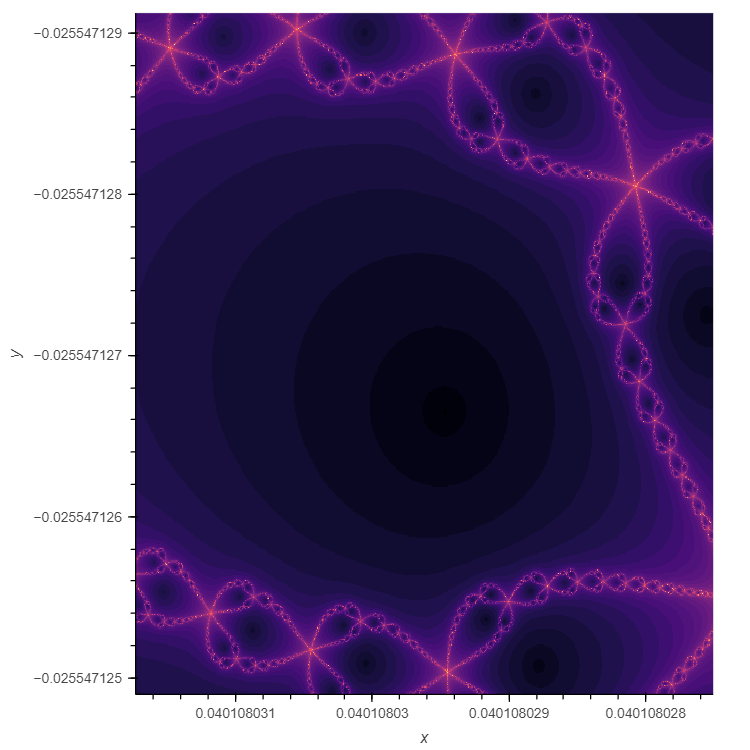